# Excess mortality in Europe on the NUTS level


In [1]:
%matplotlib notebook

import pylab as plt
import pandas as pd
import numpy as np
import seaborn as sns

import pickle

from sklearn.linear_model import LinearRegression

import geopandas as gpd
import geoplot as gplt
import geoplot.crs as gcrs

import matplotlib as mpl

import datetime

## Load mortality data and compute excess mortality

In [2]:
# https://ec.europa.eu/eurostat/databrowser/view/demo_r_mwk2_ts/default/table?lang=en

# https://ec.europa.eu/eurostat/databrowser/view/demo_r_mwk3_ts/default/table?lang=en

df = pd.read_csv('europe_nuts_data/demo_r_mwk3_ts_linear.csv.gz', sep=',')
df

,DATAFLOW,LAST UPDATE,freq,sex,unit,geo,TIME_PERIOD,OBS_VALUE,OBS_FLAG
0,ESTAT:DEMO_R_MWK3_TS(1.0),02/02/23 23:00:00,W,F,NR,AL,2015-W01,171,NaN
1,ESTAT:DEMO_R_MWK3_TS(1.0),02/02/23 23:00:00,W,F,NR,AL,2015-W02,274,NaN
2,ESTAT:DEMO_R_MWK3_TS(1.0),02/02/23 23:00:00,W,F,NR,AL,2015-W03,238,NaN
3,ESTAT:DEMO_R_MWK3_TS(1.0),02/02/23 23:00:00,W,F,NR,AL,2015-W04,304,NaN
4,ESTAT:DEMO_R_MWK3_TS(1.0),02/02/23 23:00:00,W,F,NR,AL,2015-W05,268,NaN
...,...,...,...,...,...,...,...,...,...
3410805,ESTAT:DEMO_R_MWK3_TS(1.0),02/02/23 23:00:00,W,T,NR,UKN16,2020-W47,21,p
3410806,ESTAT:DEMO_R_MWK3_TS(1.0),02/02/23 23:00:00,W,T,NR,UKN16,2020-W48,19,p
3410807,ESTAT:DEMO_R_MWK3_TS(1.0),02/02/23 23:00:00,W,T,NR,UKN16,2020-W49,16,p
3410808,ESTAT:DEMO_R_MWK3_TS(1.0),02/02/23 23:00:00,W,T,NR,UKN16,2020-W50,24,p


In [3]:
nuts = np.unique(df['geo'])
print(nuts.size)

nuts0 = np.array([u for u in nuts if len(u)==2])
print(nuts0.size)
print(nuts0)

nuts1 = np.array([u for u in nuts if len(u)==3])
print(nuts1.size)
print(nuts1)

nuts2 = np.array([u for u in nuts if len(u)==4])
print(nuts2.size)
print(nuts2)

nuts3 = np.array([u for u in nuts if len(u)==5])
print(nuts3.size)
print(nuts3)

1449
35
['AL' 'AT' 'BE' 'BG' 'CH' 'CY' 'CZ' 'DE' 'DK' 'EE' 'EL' 'ES' 'FI' 'FR'
 'HR' 'HU' 'IE' 'IS' 'IT' 'LI' 'LT' 'LU' 'LV' 'ME' 'MT' 'NL' 'NO' 'PL'
 'PT' 'RO' 'RS' 'SE' 'SI' 'SK' 'UK']
119
['AL0' 'ALX' 'AT1' 'AT2' 'AT3' 'BE1' 'BE2' 'BE3' 'BG3' 'BG4' 'BGX' 'CH0'
 'CY0' 'CZ0' 'DE1' 'DE2' 'DE3' 'DE4' 'DE5' 'DE6' 'DE7' 'DE8' 'DE9' 'DEA'
 'DEB' 'DEC' 'DED' 'DEE' 'DEF' 'DEG' 'DK0' 'EE0' 'EL3' 'EL4' 'EL5' 'EL6'
 'ELX' 'ES1' 'ES2' 'ES3' 'ES4' 'ES5' 'ES6' 'ES7' 'ESX' 'FI1' 'FI2' 'FR1'
 'FRB' 'FRC' 'FRD' 'FRE' 'FRF' 'FRG' 'FRH' 'FRI' 'FRJ' 'FRK' 'FRL' 'FRM'
 'FRY' 'HR0' 'HU1' 'HU2' 'HU3' 'HUX' 'IE0' 'IS0' 'ITC' 'ITF' 'ITG' 'ITH'
 'ITI' 'LI0' 'LT0' 'LU0' 'LV0' 'LVX' 'ME0' 'MT0' 'NL1' 'NL2' 'NL3' 'NL4'
 'NO0' 'PL2' 'PL4' 'PL5' 'PL6' 'PL7' 'PL8' 'PL9' 'PT1' 'PT2' 'PT3' 'PTX'
 'RO1' 'RO2' 'RO3' 'RO4' 'RS1' 'RS2' 'SE1' 'SE2' 'SE3' 'SI0' 'SK0' 'UKC'
 'UKD' 'UKE' 'UKF' 'UKG' 'UKH' 'UKI' 'UKJ' 'UKK' 'UKL' 'UKM' 'UKN']
271
['AL01' 'AL02' 'AL03' 'ALXX' 'AT11' 'AT12' 'AT13' 'AT21' 'AT22' 'AT31'
 'AT32' '

In [4]:
%%time

total_excess = {}
weekly_excess = {}

baselinesum = {}

for nut in nuts:
    # Unclear what those NUT units are
    if 'X' in nut:
        continue
    
    print('.', end='')
    df_subset = df[(df['geo']==nut) & (df['sex'] == 'T')]

    t = df_subset['TIME_PERIOD'].values
    d = df_subset['OBS_VALUE'].values

    year = np.array([int(s[:4]) for s in t])
    week = np.array([int(s[6:]) for s in t])

    train = (year >= 2015) & (year < 2020) & (week <= 52)
    
    # Check that there is enough training data
    if np.sum(train) < 100:
        continue

    onehot = np.zeros((np.sum(train), 52))
    for i,k in enumerate(week[train]):
        onehot[i,k-1] = 1
    predictors = np.concatenate((year[train][:,np.newaxis], onehot), axis=1)
    reg = LinearRegression(fit_intercept=False).fit(predictors, d[train][:,np.newaxis])

    test = (year >= 2020)

    # Remove the last two weeks! They may be incomplete
    test[-2:] = False
    
    if np.sum(test) == 0:
        continue

    onehot = np.zeros((np.sum(test), 52))
    for i,k in enumerate(week[test]):
        if k < 53:
            onehot[i,k-1] = 1
        else:
            onehot[i,51] = 1
    predictors = np.concatenate((year[test][:,np.newaxis], onehot), axis=1)
    prediction = reg.predict(predictors).flatten()
    
    baselinesum[nut] = np.sum(prediction[:53])
        
    weekly_excess[nut] = d[test] - prediction
    total_excess[nut] = np.sum(weekly_excess[nut][9:])

print('')

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [5]:
pickle.dump([total_excess, weekly_excess, baselinesum], open('europe-nuts-pickle.pickle', 'wb'))

In [6]:
[total_excess, weekly_excess, baselinesum] = pickle.load(open('europe-nuts-pickle.pickle', 'rb'))

## Load population data and normalize excess mortality

In [7]:
# https://ec.europa.eu/eurostat/databrowser/view/DEMO_R_D2JAN/default/table?lang=en&category=demo.demopreg

# https://ec.europa.eu/eurostat/databrowser/view/demo_r_pjanaggr3/default/table?lang=en

df_pop = pd.read_csv('europe_nuts_data/demo_r_pjanaggr3_linear.csv.gz', sep=',')

df_pop

,DATAFLOW,LAST UPDATE,freq,unit,sex,age,geo,TIME_PERIOD,OBS_VALUE,OBS_FLAG
0,ESTAT:DEMO_R_PJANAGGR3(1.0),02/06/22 23:00:00,A,NR,F,TOTAL,AL,2000,1526762.0,NaN
1,ESTAT:DEMO_R_PJANAGGR3(1.0),02/06/22 23:00:00,A,NR,F,TOTAL,AL,2001,1535822.0,NaN
2,ESTAT:DEMO_R_PJANAGGR3(1.0),02/06/22 23:00:00,A,NR,F,TOTAL,AL,2002,1532563.0,NaN
3,ESTAT:DEMO_R_PJANAGGR3(1.0),02/06/22 23:00:00,A,NR,F,TOTAL,AL,2003,1526180.0,NaN
4,ESTAT:DEMO_R_PJANAGGR3(1.0),02/06/22 23:00:00,A,NR,F,TOTAL,AL,2004,1520481.0,NaN
...,...,...,...,...,...,...,...,...,...,...
621600,ESTAT:DEMO_R_PJANAGGR3(1.0),02/06/22 23:00:00,A,NR,T,Y_LT15,UKN16,2015,23318.0,NaN
621601,ESTAT:DEMO_R_PJANAGGR3(1.0),02/06/22 23:00:00,A,NR,T,Y_LT15,UKN16,2016,23394.0,NaN
621602,ESTAT:DEMO_R_PJANAGGR3(1.0),02/06/22 23:00:00,A,NR,T,Y_LT15,UKN16,2017,23555.0,NaN
621603,ESTAT:DEMO_R_PJANAGGR3(1.0),02/06/22 23:00:00,A,NR,T,Y_LT15,UKN16,2018,23646.0,NaN


In [8]:
df_pop_reduced = df_pop[(df_pop.sex=='T') & (df_pop.age=='TOTAL') & (df_pop.TIME_PERIOD==2019)]

populations = dict(zip(df_pop_reduced.geo, df_pop_reduced.OBS_VALUE))

In [9]:
total_excess_per100k = {}
weekly_excess_per100k = {}

for nut in total_excess:
    if nut in populations and populations[nut] > 0:
        total_excess_per100k[nut] = total_excess[nut] / populations[nut] * 100_000
        weekly_excess_per100k[nut] = weekly_excess[nut] / populations[nut] * 100_000

In [10]:
# Top-10

keys = list(total_excess_per100k.keys())
vals = list(total_excess_per100k.values())

ind = np.argsort(vals)[::-1]
for i in ind[:10]:
    print(f'{keys[i]:5} {int(vals[i])}')

BG311 1578
BG322 1341
BG324 1330
BG312 1280
BG415 1273
LT027 1246
BG414 1245
BG422 1159
BG423 1154
BG325 1150


In [11]:
# P-scores

total_excess_normalized = {}
weekly_excess_normalized = {}

for nut in total_excess:
    if baselinesum[nut] > 0:
        total_excess_normalized[nut] = total_excess[nut] / baselinesum[nut] * 100
        weekly_excess_normalized[nut] = weekly_excess[nut] / baselinesum[nut] * 100

In [12]:
# Top-10

keys = list(total_excess_normalized.keys())
vals = list(total_excess_normalized.values())

ind = np.argsort(vals)[::-1]
for i in ind[:10]:
    print(f'{keys[i]:5} {int(vals[i])}')

LT027 86
RO415 82
EL532 77
BG324 77
BG425 75
ES424 74
BG423 73
BG413 72
ITC4A 71
CH063 71


## Load spatial data

In [13]:
df_geo = gpd.read_file('europe_nuts_data/NUTS_RG_10M_2021_4326.shp.zip')

df_geo

,NUTS_ID,LEVL_CODE,CNTR_CODE,NAME_LATN,NUTS_NAME,MOUNT_TYPE,URBN_TYPE,COAST_TYPE,FID,geometry
0,BG423,3,BG,Pazardzhik,Пазарджик,3.0,2.0,3,BG423,"POLYGON ((24.42101 42.55306, 24.41032 42.46950..."
1,BG424,3,BG,Smolyan,Смолян,3.0,3.0,3,BG424,"POLYGON ((25.07422 41.79348, 25.05851 41.75177..."
2,BG425,3,BG,Kardzhali,Кърджали,3.0,3.0,3,BG425,"POLYGON ((25.94863 41.32034, 25.90644 41.30757..."
3,CH011,3,CH,Vaud,Vaud,3.0,2.0,3,CH011,"MULTIPOLYGON (((6.86623 46.90929, 6.89621 46.9..."
4,CH012,3,CH,Valais,Valais,3.0,2.0,3,CH012,"POLYGON ((8.47767 46.52760, 8.39953 46.48872, ..."
...,...,...,...,...,...,...,...,...,...,...
2005,LV,0,LV,Latvija,Latvija,0.0,NaN,0,LV,"POLYGON ((27.35158 57.51824, 27.54521 57.53444..."
2006,ME,0,ME,Crna Gora,Црна Гора,0.0,NaN,0,ME,"POLYGON ((20.06394 43.00682, 20.32958 42.91149..."
2007,MK,0,MK,Severna Makedonija,Северна Македонија,0.0,NaN,0,MK,"POLYGON ((22.36021 42.31116, 22.51041 42.15516..."
2008,SK0,1,SK,Slovensko,Slovensko,0.0,NaN,0,SK0,"POLYGON ((19.88393 49.20418, 19.96275 49.23031..."


In [14]:
%%time

# Populate the dataframe with my estimates

for nut in total_excess:
    df_geo.loc[df_geo.NUTS_ID==nut, 'total_excess'] = total_excess[nut]    
    
for nut in total_excess_normalized:
    df_geo.loc[df_geo.NUTS_ID==nut, 'total_excess_normalized'] = total_excess_normalized[nut]

for nut in total_excess_per100k:
    df_geo.loc[df_geo.NUTS_ID==nut, 'total_excess_per100k'] = total_excess_per100k[nut]
    
    for w in range(1, 54):
        if w-1 >= weekly_excess_per100k[nut].size:
            break
        df_geo.loc[df_geo.NUTS_ID==nut, f'weekly_excess_per100k_2020_w{w}'] = weekly_excess_per100k[nut][w-1]
    for w in range(1, 53):
        if w-1+53 >= weekly_excess_per100k[nut].size:
            break
        df_geo.loc[df_geo.NUTS_ID==nut, f'weekly_excess_per100k_2021_w{w}'] = weekly_excess_per100k[nut][w-1+53]
    for w in range(1, 53):
        if w-1+53+52 >= weekly_excess_per100k[nut].size:
            break
        df_geo.loc[df_geo.NUTS_ID==nut, f'weekly_excess_per100k_2022_w{w}'] = weekly_excess_per100k[nut][w-1+53+52]
    for w in range(1, 53):
        if w-1+53+52+52 >= weekly_excess_per100k[nut].size:
            break
        df_geo.loc[df_geo.NUTS_ID==nut, f'weekly_excess_per100k_2023_w{w}'] = weekly_excess_per100k[nut][w-1+53+52+52]
        
    df_geo = df_geo.copy()

CPU times: user 1min 2s, sys: 104 ms, total: 1min 2s
Wall time: 1min 2s


In [15]:
# For countries not in EU

world = gpd.read_file('europe_nuts_data/CNTR_RG_10M_2020_4326.shp.zip')

world2 = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [16]:
# plt.figure(figsize=(8,4))
# # plt.plot(weekly_excess['RS221'])

# df_subset = df[(df['geo']=='FI1D8')] # & (df['sex'] == 'T')]
# t = df_subset['TIME_PERIOD'].values
# d = df_subset['OBS_VALUE'].values
# plt.plot(d,'.-')
# sns.despine()
# plt.tight_layout()

# total_excess['FI1D8']

# for n in nuts:
#     if n[:2]=='FI':
#         print(f'{n:8}', populations[n])

## Make figures

In [17]:
london_divisions = np.array([a[:3]=='UKI' and len(a)>3 for a in df_geo['NUTS_ID']])

serbia_nuts3 = np.array([a[:2]=='RS' and len(a)>4 for a in df_geo['NUTS_ID']])

uk_nuts3 = np.array([a[:2]=='UK' and len(a)>4 for a in df_geo['NUTS_ID']])

belgium_nl_nuts3 = np.array([(a[:2]=='BE' or a[:2]=='NL') and len(a)>4 for a in df_geo['NUTS_ID']])

myfilter = ~london_divisions & ~serbia_nuts3 & ~uk_nuts3 & ~belgium_nl_nuts3


def make_nuts_figure(hue, vmax, label, corner_label=None):
    norm = mpl.colors.Normalize(vmin=0, vmax=vmax)

    ax = gplt.choropleth(df_geo[(df_geo.LEVL_CODE == 0) & ~np.isnan(df_geo[hue])], 
                         hue=hue,
                         figsize=(8,4.5), 
                         cmap='Reds', 
                         linewidth=.25, 
                         edgecolor='#555555', 
                         norm=norm,
                         projection = gcrs.AlbersEqualArea())
    
    gplt.polyplot(df_geo[(df_geo.LEVL_CODE == 0) & np.isnan(df_geo[hue]) & 
                         ~np.isnan(df_geo['total_excess_per100k'])], 
                       ax=ax, linewidth=0, color='#aaaaaa',
                       projection = gcrs.AlbersEqualArea())

    gplt.choropleth(df_geo[(df_geo.LEVL_CODE == 1) & ~np.isnan(df_geo[hue]) & myfilter], 
                    hue=hue,
                    ax=ax,
                    cmap='Reds',
                    linewidth=.25,
                    edgecolor='#555555',
                    norm=norm,
                    projection = gcrs.AlbersEqualArea())

    gplt.choropleth(df_geo[(df_geo.LEVL_CODE == 2) & ~np.isnan(df_geo[hue]) & myfilter],
                    hue=hue,
                    ax=ax,
                    cmap='Reds',
                    linewidth=.25,
                    edgecolor='#555555',
                    norm=norm,
                    projection = gcrs.AlbersEqualArea())

    gplt.choropleth(df_geo[(df_geo.LEVL_CODE == 3) & ~np.isnan(df_geo[hue]) & myfilter],
                    hue=hue,
                    ax=ax,
                    cmap='Reds',
                    linewidth=.25,
                    edgecolor='#555555',
                    norm=norm,
                    projection = gcrs.AlbersEqualArea(),
                    legend=True,
                    legend_kwargs={'shrink': 0.5, 'label':label})

    for c in ['Ireland', 'Bosnia and Herzegovina', 'Montenegro', 'North Macedonia']:
        gplt.polyplot(world[world.NAME_ENGL==c],
                      ax=ax, linewidth=0, color='#aaaaaa',
                      projection = gcrs.AlbersEqualArea())
    for c in ['Kosovo']:
        gplt.polyplot(world2[world2.name==c],
                      ax=ax, linewidth=0, color='#aaaaaa',
                      projection = gcrs.AlbersEqualArea())

    plt.xlim(-1176025.4049531068, 2773452.1162291295)
    plt.ylim(607325.5283996068, 4925400.064063436)

    plt.title('Excess deaths in Europe during Covid-19 pandemic', x=.55)

    plt.tight_layout()

    plt.gcf().text(.95, .05, '''Data: Eurostat\nAnalysis: Dmitry Kobak, @hippopedoid\n'''
               f'''Last update: {datetime.date.today():%b %d, %Y}''', ha='right', fontsize=7)
    
    if corner_label is not None:
        plt.gcf().text(.05, .85, corner_label)

    pos1 = ax.get_position() # get the original position 
    pos2 = [pos1.x0 - 0.1, pos1.y0,  pos1.width, pos1.height] 
    ax.set_position(pos2) # set a new position

<IPython.core.display.Javascript object>


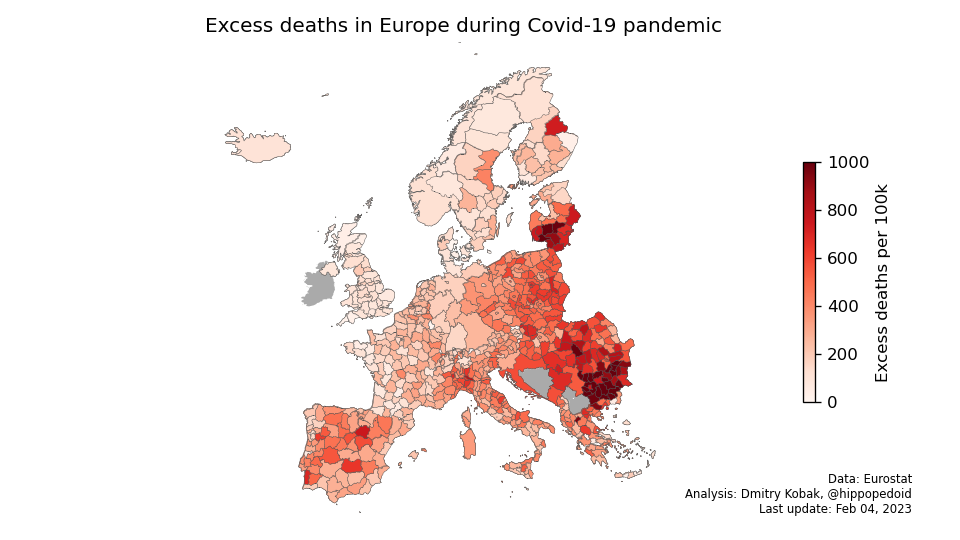

In [18]:
make_nuts_figure('total_excess_per100k', 1000, 'Excess deaths per 100k')

plt.savefig('img/europe_nuts_excess_per_100k.png', dpi=200)

<IPython.core.display.Javascript object>


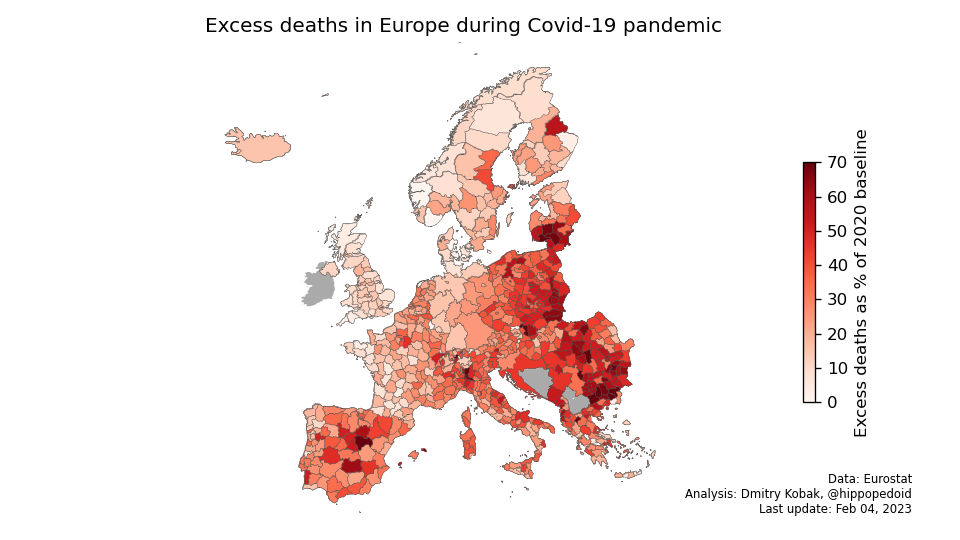

In [19]:
make_nuts_figure('total_excess_normalized', 70, 'Excess deaths as % of 2020 baseline')

plt.savefig('img/europe_nuts_excess_normalized.png', dpi=200)

In [24]:
%%time

from IPython.display import clear_output

for w in range(1, 1+len(weekly_excess['DE'])):
    if w <= 53:
        year = 2020
        week = w
    elif w <= 53 + 52:
        year = 2021
        week = w - 53
    elif w <= 53 + 52 + 52:
        year = 2022
        week = w - 53 - 52
    else:
        year = 2023
        week = w - 53 - 52 - 52  
        
    make_nuts_figure(f'weekly_excess_per100k_{year}_w{week}', 80, 'Excess deaths per 100k',
                     f'{year}, week {week}')

    plt.savefig(f'img/europe-nuts-animation/{w:03}.png', dpi=200)
    
    clear_output(wait=True)

CPU times: user 6min 14s, sys: 2.16 s, total: 6min 16s
Wall time: 6min 16s


In [18]:
# ffmpeg -framerate 5 -pattern_type glob -i 'img/europe-nuts-animation/*.png' -c:v libx264 -pix_fmt yuv420p img/europe_nuts_excess_per_100k_animation.mp4